In [1]:
# Importing Packages for Data Analysis:
import numpy as np
import pandas as pd
import sweetviz as sv
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
def IQR_Rejection(data_frame, column_name):
    q1 = data_frame[column_name].quantile(0.25)
    q3 = data_frame[column_name].quantile(0.75)
    iqr = q3 - q1
    fence_low  = q1 - 1.5*iqr
    fence_high = q3 + 1.5*iqr
    df_out = data_frame.loc[(data_frame[column_name] > fence_low) & (data_frame[column_name] < fence_high)]
    
    return df_out

In [3]:
def filter_Outliers(df):
    filt_df = IQR_Rejection(IQR_Rejection(df, 'Total_Amt_Outflow_L3M'), 'Total_Amt_Inflow_L3M')
    return filt_df

In [4]:
def binarize_cols(df):
    for (columnName, columnData) in filt_df.iteritems():
        if (columnData.unique().size > 3) & ((columnData == 0).mean() > 0.5):
            filt_df[columnName] = np.where(columnData == 0, 0, 1)
    return filt_df

In [5]:
def prepare_data(data_path, keep_outliers=False, binarize_cols=True, split_structure=True):
    # Read in the data frame using Pandas
    df = pd.read_csv(data_path, sep='|')
    df = df.drop(['ClientIdentifier', 'Behaviour_Date_Key'], axis=1)
    df = df.drop(['Instalment_Amt_All', 'Current_Balance_All', 'ALL_Max_Delq_Ever'], axis=1)
    df['Has_Deed'] = df['Has_Deed'].map({'Y': 1, 'N': 0})
    df = df.dropna()
    behaviours = df.BehaviourType.unique()
    behaviours.sort()
    
    if split_structure:
        frame_storage = []
        for i in range(0, len(behaviours), 2):
            new_frame = df[df['BehaviourType'] == behaviours[i]]
            new_not_frame = df[df['BehaviourType'] == behaviours[i+1]]
            frame = pd.concat([new_frame, new_not_frame])
            frame_storage.append(frame)

        newFrames = {'APP': frame_storage[0],
                     'BANK': frame_storage[1],
                     'CARD': frame_storage[2],
                     'CREDIT': frame_storage[3],
                     'DEBIT': frame_storage[4],
                     'FIN_ED': frame_storage[5],
                     'LOAN': frame_storage[6],
                     'SAVE': frame_storage[7],
                     'VIRT_CARD': frame_storage[8]}
    else:
        return df
    
    if keep_outliers == False:
        for key, value in newFrames.items():
            newFrames[key] = filter_Outliers(value)
    if binarize_cols == True:
        for key, value in newFrames.items():
            newFrames[key] = binarize_cols(value)
    
    return newFrames

In [6]:
#COPY
def prepare_data_sample(data_path, keep_outliers=False, binarize_cols=True, split_structure=True):
    # Read in the data frame using Pandas
    df = pd.read_csv(data_path, sep='|')
    df = df.drop(['ClientIdentifier', 'Behaviour_Date_Key'], axis=1)
    df = df.drop(['Instalment_Amt_All', 'Current_Balance_All', 'ALL_Max_Delq_Ever'], axis=1)
    df['Has_Deed'] = df['Has_Deed'].map({'Y': 1, 'N': 0})
    df = df.dropna()
    behaviours = df.BehaviourType.unique()
    behaviours.sort()
    
    if split_structure:
        frame_storage = []
        for i in range(0, len(behaviours), 2):
            new_frame = df[df['BehaviourType'] == behaviours[i]]
            new_not_frame = df[df['BehaviourType'] == behaviours[i+1]].sample(frac=0.05)
            frame = pd.concat([new_frame, new_not_frame])
            frame_storage.append(frame)

        newFrames = {'APP': frame_storage[0],
                     'BANK': frame_storage[1],
                     'CARD': frame_storage[2],
                     'CREDIT': frame_storage[3],
                     'DEBIT': frame_storage[4],
                     'FIN_ED': frame_storage[5],
                     'LOAN': frame_storage[6],
                     'SAVE': frame_storage[7],
                     'VIRT_CARD': frame_storage[8]}
    else:
        return df
    
    if keep_outliers == False:
        for key, value in newFrames.items():
            newFrames[key] = filter_Outliers(value)
    if binarize_cols == True:
        for key, value in newFrames.items():
            newFrames[key] = binarize_cols(value)
    
    return newFrames

In [7]:
dfs = prepare_data('../datasets/ClientBehaviourTraining.txt', binarize_cols=False)
dfs2 =  prepare_data_sample('../datasets/ClientBehaviourTraining.txt', binarize_cols=False)
#print(dfs['APP'])

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, balanced_accuracy_score, recall_score
from sklearn.ensemble import GradientBoostingClassifier

In [9]:
class BinarySubset():

    _name = None
    _df = None
    _X_train = None
    _X_test = None
    _y_train = None
    _y_test = None
    _target = None
    _scaled = None
    
    _pca_data = None
    _pca_trans = None
    _pca_cols = None
    _pca_suc = False
    
    _model = None
    _predictions = None
    _classification_report = None
    _roc_curve = None
    
    def __init__(self, data, name, use_PCA=False):
        self._name = name
        self._df= data
        self._target = self.create_target()
        self._scaled = self.scale_df()
        if use_PCA:
            self.pca_fit_transform(0.9)
            self.create_train_test_split(use_PCA)
        else:
            self.create_train_test_split()

    def create_target(self) -> np.array:
        target = LabelEncoder().fit_transform(self._df.BehaviourType)
        return target
    
    def scale_df(self) -> pd.DataFrame:
        cols = self._df.select_dtypes(include=("float64", "int64")).columns
        ldscaled = StandardScaler().fit_transform(self._df.select_dtypes(include=("float64", "int64")))
        ldscaled = pd.DataFrame(ldscaled, columns=cols)
        return ldscaled
    
    def create_train_test_split(self, use_PCA=False):
        if use_PCA and self._pca_suc:
            self._X_train, self._X_test, self._y_train, self._y_test = train_test_split(self._pca_data, self._target, random_state=21)
        else:
            self._X_train, self._X_test, self._y_train, self._y_test = train_test_split(self._scaled, self._target, random_state=21)
        
    def fit_LogisticRegression(self, X, y):
        self._model = LogisticRegression(max_iter=10000)
        self._model.fit(X, y)
    
    def fit_ModLogReg(self, X, y):
        self._model = LogisticRegression(max_iter=10000, class_weight='balanced', solver='saga')
        self._model.fit(X, y)
    
    def fit_KNN(self, X, y):
        self._model = KNeighborsClassifier(n_neighbors=7)
        self._model.fit(X, y)
    
    def fit_dt(self, X, y):
        self._model = DecisionTreeClassifier(max_depth=None)
        self._model.fit(X, y)
        
    def fit_nb(self, X, y):
        self._model = GaussianNB()
        self._model.fit(X, y)
    
    def fit_GB(self, X, y):
        self._model = GradientBoostingClassifier()
        self._model.fit(X, y)
    
    def fit_rf(self, X, y):
        self._model = RandomForestClassifier(n_estimators = 50, ccp_alpha = 0.01)
        self._model.fit(X, y)
    
    def fit_nn(self, X, y):
        self._model = MLPClassifier(activation = 'logistic', solver='sgd', hidden_layer_sizes=(100), random_state=1, learning_rate='adaptive', learning_rate_init=0.9, max_iter=10000)
        self._model.fit(X, y)
    
    def predict(self, X):
        self._predictions = self._model.predict(X)
        self.classification_report()
        self.roc_curve()
    
    def classification_report(self):
        self._classification_report = classification_report(y_true=self._y_test, y_pred=self._predictions)
    
    def roc_curve(self):
        self._roc_curve = roc_curve(y_true=self._y_test, y_score=self._predictions)
    
    def add_roc_curve(self, axes=None, ex_name=''):
        if axes is None:
            metrics.plot_roc_curve(self._model, self._X_test, self._y_test)
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')
            plt.show()
        else:
            RocCurveDisplay.from_estimator(self._model, self._X_test, self._y_test, ax=axes, name=self._name+ex_name)
    
    def print_roc(self):
        metrics.plot_roc_curve(self._model, self._X_test, self._y_test)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
    
    def pca_fit_transform(self, explained_var):
        '''
        INPUT: n in range(0,1) that represents the amount of variance you would like to keep
        '''
        i = 0
        var = 0
        cols = list()
        while var < explained_var and i < len(self._scaled):
            if i != 0: cols.append(f"PC{i}")
            pca = PCA(n_components=i).fit(self._scaled)
            var = np.sum(pca.explained_variance_ratio_)
            i = i + 1
        if i < len(self._scaled):
            print('PCA Complete!')
            self._pca_trans = pca
            self._pca_data  = pd.DataFrame(pca.transform(self._scaled), columns=cols)
            self._pca_cols = cols
            self._pca_suc = True
        else:
            print('PCA Failed')
            self._pca_suc = False
            

In [27]:
use_PCA = False
logReg = [BinarySubset(value, key, use_PCA) for key, value in dfs.items()]
KNN = [BinarySubset(value, key, use_PCA) for key, value in dfs.items()]
DecTree = [BinarySubset(value, key, use_PCA) for key, value in dfs.items()]
Bayes = [BinarySubset(value, key, use_PCA) for key, value in dfs.items()]
RandFor = [BinarySubset(value, key, use_PCA) for key, value in dfs.items()]
#NN = [BinarySubset(value, key, use_PCA) for key, value in dfs.items()]
#GB = [BinarySubset(value, key, use_PCA) for key, value in dfs.items()]
#modLogReg = [BinarySubset(value, key, use_PCA) for key, value in dfs.items()]
#modLogRegSamp = [BinarySubset(value, key, use_PCA) for key, value in dfs2.items()]

def print_roc(model, file_name):
    fig, ax = plt.subplots()
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')

    for i in model:
        i.add_roc_curve(ax)
    plt.legend()
    plt.savefig(file_name)
    plt.show()

def print_class_rep():
    for i in subsets:
        print(i._name+"\n"+i._classification_report)

**Logistic Regression**

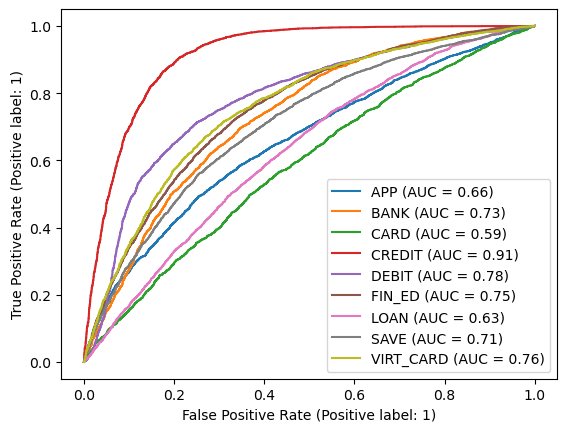

In [28]:
lg = []
for i in logReg:
    i.fit_LogisticRegression(i._X_train, i._y_train)
    i.predict(i._X_test)
    lg.append(i)
print_roc(logReg, 'Logsitic Regression.png')
#print_class_rep()

***KNN Search***

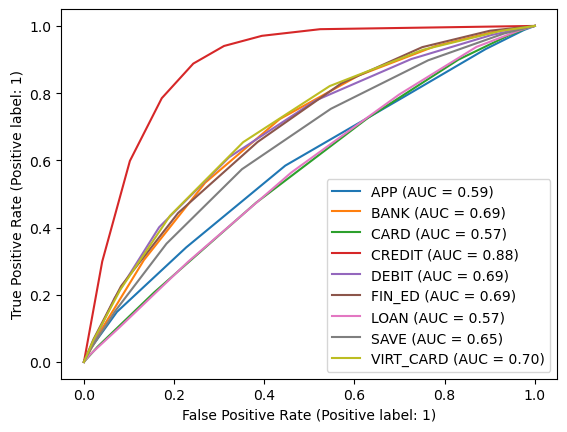

In [12]:
knn = []
for i in KNN:
    i.fit_KNN(i._X_train, i._y_train)
    i.predict(i._X_test)
    knn.append(i)
print_roc(KNN)
#print_class_rep()

***Decision Tree***

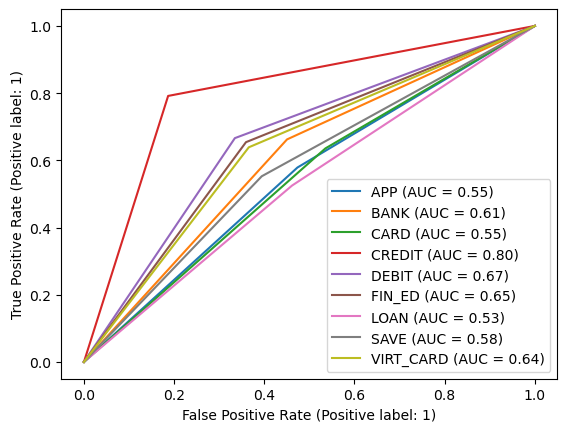

In [13]:
dt = []
for i in DecTree:
    i.fit_dt(i._X_train, i._y_train)
    i.predict(i._X_test)
    dt.append(i)
print_roc(DecTree)
#print_class_rep()

**Naive Bayes**

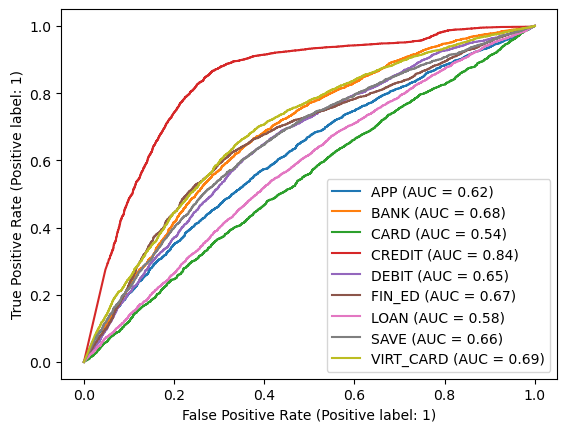

In [14]:
nb = []
for i in Bayes:
    i.fit_nb(i._X_train, i._y_train)
    i.predict(i._X_test)
    nb.append(i)
print_roc(Bayes)
#print_class_rep()

**Random Forest**

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

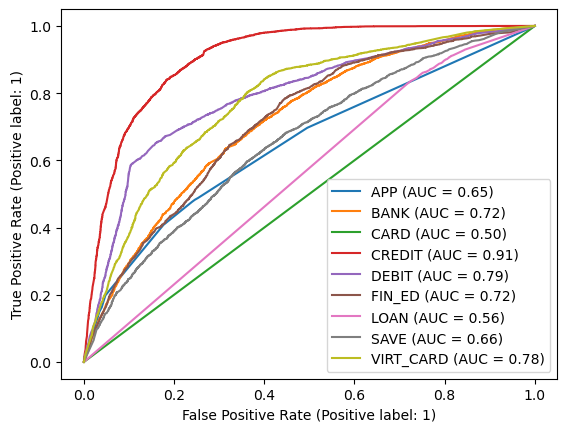

In [15]:
rf = []
for i in RandFor:
    i.fit_rf(i._X_train, i._y_train)
    i.predict(i._X_test)
    rf.append(i)
print_roc(RandFor)

**Neural Network**

In [16]:
#nn = []
#for i in NN:
    #i.fit_nn(i._X_train, i._y_train)
    #i.predict(i._X_test)
    #nn.append(i)
    #print("Converged: {}".format(i))
#print_roc(NN)

**Gradient Boost**

In [17]:
#gb = []
#for i in GB:
    #i.fit_GB(i._X_train, i._y_train)
    #i.predict(i._X_test)
    #gb.append(i)
    #print("Converged: {}".format(i))
#print_roc(GB)

**Modified LogReg**

In [18]:
#mlg = []
#for i in modLogReg:
    #i.fit_ModLogReg(i._X_train, i._y_train)
    #i.predict(i._X_test)
    #mlg.append(i)
    #print("Converged: {}".format(i))
#print_roc(modLogReg)

**Modified LogReg Sampled**

In [19]:
#mlgs = []
#for i in modLogRegSamp:
    #i.fit_ModLogReg(i._X_train, i._y_train)
    #i.predict(i._X_test)
    #mlgs.append(i)
    #print("Converged: {}".format(i))
#print_roc(modLogRegSamp)

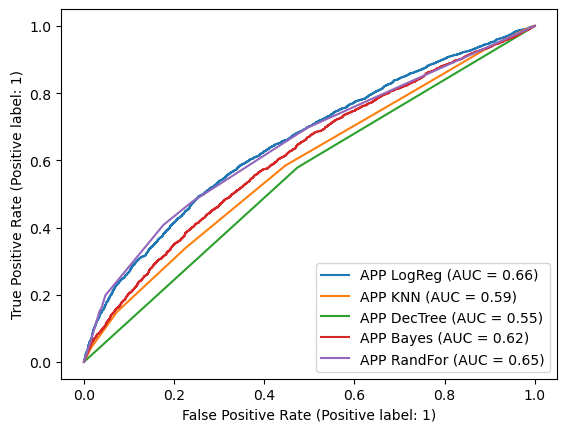

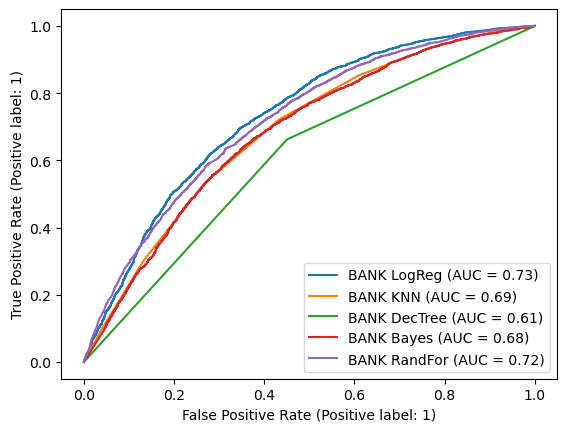

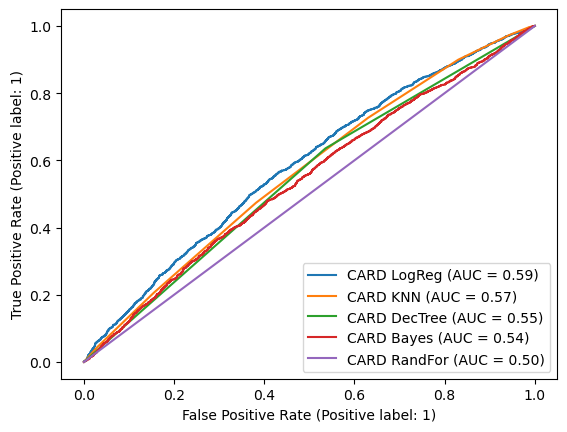

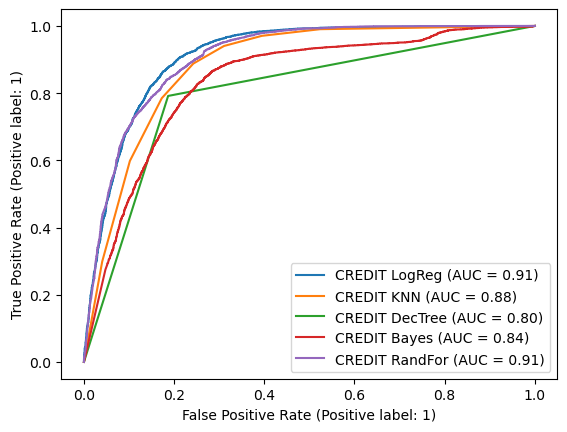

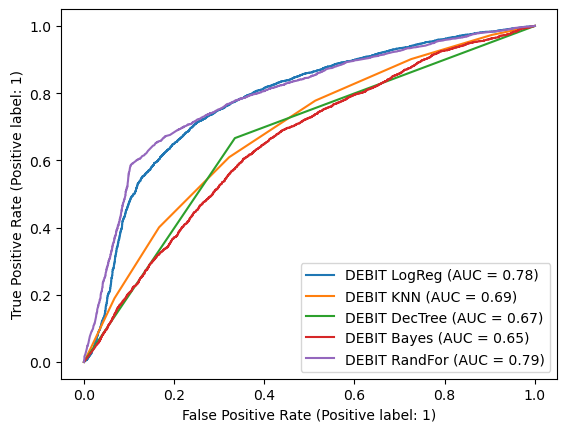

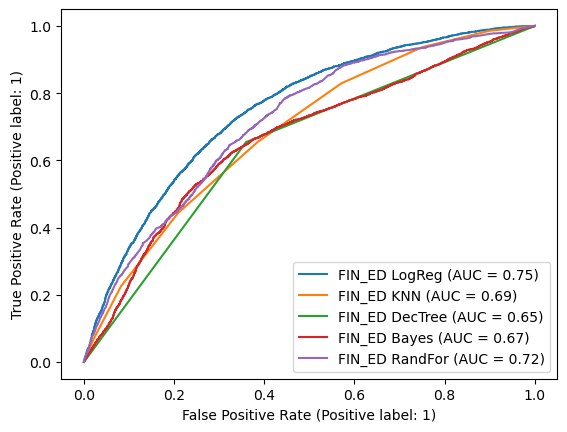

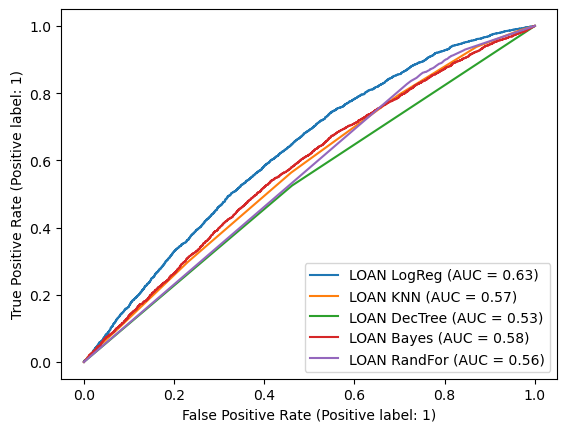

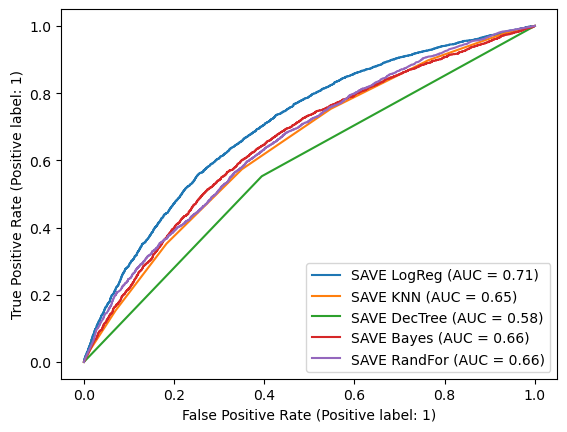

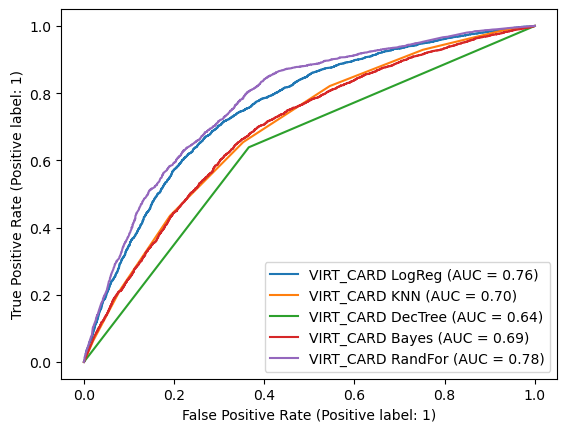

In [29]:

for i in range(len(lg)):
    fig, ax = plt.subplots()
    lg[i].add_roc_curve(axes=ax,ex_name=' LogReg')
    knn[i].add_roc_curve(axes=ax,ex_name=' KNN')
    dt[i].add_roc_curve(axes=ax, ex_name=' DecTree')
    nb[i].add_roc_curve(axes=ax, ex_name=' Bayes')
    rf[i].add_roc_curve(axes=ax, ex_name=' RandFor')
    if i == 2:
        plt.savefig('Card.png')
    elif i == 3:
        plt.savefig('Credit.png')
    #gb[i].add_roc_curve(axes=ax, ex_name=' GB')
    #mlg[i].add_roc_curve(axes=ax, ex_name=' Modified LG')
    #mlgs[i].add_roc_curve(axes=ax, ex_name=' MLG Sampled')
    plt.show()
    

In [21]:
# Load and Prune Eval Set:
split = True
eval_set = prepare_data('../datasets/ClientBehaviourEvaluation.txt', keep_outliers=True, binarize_cols=False, split_structure=split)

if split:
    ldscaled ={}
    true_vals = {}
    for keys, vals in eval_set.items():
        start_index = 1
        true = pd.get_dummies(eval_set[keys]['BehaviourType'])
        true_vals[keys] = true.iloc[:,[1]]

        cols = eval_set[keys].select_dtypes(include=("float64", "int64")).columns
        scale_frame = StandardScaler().fit_transform(eval_set[keys].select_dtypes(include=("float64", "int64")))
        ldscaled[keys] = pd.DataFrame(scale_frame, columns=cols)
else:
    true_vals = {}
    start_index = 1
    true = pd.get_dummies(eval_set['BehaviourType'])
    for key, i in zip(keys, range(start_index, 17+start_index, 2)):
        true_vals[key] = true.iloc[:,[i]]

    cols = eval_set.select_dtypes(include=("float64", "int64")).columns
    ldscaled = StandardScaler().fit_transform(eval_set.select_dtypes(include=("float64", "int64")))
    ldscaled = pd.DataFrame(ldscaled, columns=cols)

In [22]:
for keys, i in zip(true_vals.keys(), range(len(logReg))):
    print('{}:'.format(keys))

    if logReg[i]._pca_suc and use_PCA:
        score_logreg = balanced_accuracy_score(true_vals[keys], logReg[i]._model.predict(pd.DataFrame(logReg[i]._pca_trans.transform(ldscaled[keys]), columns=logReg[i]._pca_cols)))
        recall_logreg = recall_score(true_vals[keys], logReg[i]._model.predict(pd.DataFrame(logReg[i]._pca_trans.transform(ldscaled[keys]), columns=logReg[i]._pca_cols)))
    else:
        score_logreg = balanced_accuracy_score(true_vals[keys], logReg[i]._model.predict(ldscaled[keys]))
        recall_logreg = recall_score(true_vals[keys], logReg[i]._model.predict(ldscaled[keys]))
    print("\tLogistic: {:.3f}, {:.3f}".format(score_logreg, recall_logreg))


    if KNN[i]._pca_suc and use_PCA:
        score_knn = balanced_accuracy_score(true_vals[keys], KNN[i]._model.predict(pd.DataFrame(KNN[i]._pca_trans.transform(ldscaled[keys]), columns=KNN[i]._pca_cols)))
        recall_knn = recall_score(true_vals[keys], KNN[i]._model.predict(pd.DataFrame(KNN[i]._pca_trans.transform(ldscaled[keys]), columns=KNN[i]._pca_cols)))
    else:
        score_knn = balanced_accuracy_score(true_vals[keys], KNN[i]._model.predict(ldscaled[keys]))
        recall_knn = recall_score(true_vals[keys], KNN[i]._model.predict(ldscaled[keys]))
    print("\tKNN: {:.3f}, {:.3f}".format(score_knn, recall_knn))


    if DecTree[i]._pca_suc and use_PCA:
        score_dt = balanced_accuracy_score(true_vals[keys], DecTree[i]._model.predict(pd.DataFrame(DecTree[i]._pca_trans.transform(ldscaled[keys]), columns=DecTree[i]._pca_cols)))
        recall_dt = recall_score(true_vals[keys], DecTree[i]._model.predict(pd.DataFrame(DecTree[i]._pca_trans.transform(ldscaled[keys]), columns=DecTree[i]._pca_cols)))
    else:
        score_dt = balanced_accuracy_score(true_vals[keys], DecTree[i]._model.predict(ldscaled[keys]))
        recall_dt = recall_score(true_vals[keys], DecTree[i]._model.predict(ldscaled[keys]))
    print("\tDecision Tree: {:.3f}, {:.3f}".format(score_dt, recall_dt))


    if Bayes[i]._pca_suc and use_PCA:
        score_bayes = balanced_accuracy_score(true_vals[keys], Bayes[i]._model.predict(pd.DataFrame(Bayes[i]._pca_trans.transform(ldscaled[keys]), columns=Bayes[i]._pca_cols)))
        recall_bayes = recall_score(true_vals[keys], Bayes[i]._model.predict(pd.DataFrame(Bayes[i]._pca_trans.transform(ldscaled[keys]), columns=Bayes[i]._pca_cols)))
    else:
        score_bayes = balanced_accuracy_score(true_vals[keys], Bayes[i]._model.predict(ldscaled[keys]))
        recall_bayes = recall_score(true_vals[keys], Bayes[i]._model.predict(ldscaled[keys]))
    print("\tBayes: {:.3f}, {:.3f}".format(score_bayes, recall_bayes))


    if RandFor[i]._pca_suc and use_PCA:
        score_rf = balanced_accuracy_score(true_vals[keys], RandFor[i]._model.predict(pd.DataFrame(RandFor[i]._pca_trans.transform(ldscaled[keys]), columns=RandFor[i]._pca_cols)))
        recall_rf = recall_score(true_vals[keys], RandFor[i]._model.predict(pd.DataFrame(RandFor[i]._pca_trans.transform(ldscaled[keys]), columns=RandFor[i]._pca_cols)))
    else:
        score_rf = balanced_accuracy_score(true_vals[keys], RandFor[i]._model.predict(ldscaled[keys]))
        recall_rf = recall_score(true_vals[keys], RandFor[i]._model.predict(ldscaled[keys]))
    print("\tRandom Forest: {:.3f}, {:.3f}".format(score_rf, recall_rf))
    
    #if GB[i]._pca_suc and use_PCA:
        #score_gb = balanced_accuracy_score(true_vals[keys], GB[i]._model.predict(pd.DataFrame(GB[i]._pca_trans.transform(ldscaled[keys]), columns=GB[i]._pca_cols)))
        #recall_gb = recall_score(true_vals[keys], GB[i]._model.predict(pd.DataFrame(GB[i]._pca_trans.transform(ldscaled[keys]), columns=GB[i]._pca_cols)))
    #else:
        #score_gb = balanced_accuracy_score(true_vals[keys], GB[i]._model.predict(ldscaled[keys]))
        #recall_gb = recall_score(true_vals[keys], GB[i]._model.predict(ldscaled[keys]))
    #print("\tGradient Boosting: {:.3f}, {:.3f}".format(score_gb, recall_gb))

    
    #if modLogReg[i]._pca_suc and use_PCA:
        #score_mlg = balanced_accuracy_score(true_vals[keys], modLogReg[i]._model.predict(pd.DataFrame(modLogReg[i]._pca_trans.transform(ldscaled[keys]), columns=modLogReg[i]._pca_cols)))
        #recall_mlg = recall_score(true_vals[keys], modLogReg[i]._model.predict(pd.DataFrame(modLogReg[i]._pca_trans.transform(ldscaled[keys]), columns=modLogReg[i]._pca_cols)))
    #else:
        #score_mlg = balanced_accuracy_score(true_vals[keys], modLogReg[i]._model.predict(ldscaled[keys]))
        #recall_mlg = recall_score(true_vals[keys], modLogReg[i]._model.predict(ldscaled[keys]))
    #print("\tModified LogReg: {:.3f}, {:.3f}".format(score_mlg, recall_mlg))
    
    
    #if modLogRegSamp[i]._pca_suc and use_PCA:
        #score_mlgs = balanced_accuracy_score(true_vals[keys], modLogRegSamp[i]._model.predict(pd.DataFrame(modLogRegSamp[i]._pca_trans.transform(ldscaled[keys]), columns=modLogRegSamp[i]._pca_cols)))
        #recall_mlgs = recall_score(true_vals[keys], modLogRegSamp[i]._model.predict(pd.DataFrame(modLogRegSamp[i]._pca_trans.transform(ldscaled[keys]), columns=modLogRegSamp[i]._pca_cols)))
    #else:
        #score_mlgs = balanced_accuracy_score(true_vals[keys], modLogRegSamp[i]._model.predict(ldscaled[keys]))
        #recall_mlgs = recall_score(true_vals[keys], modLogRegSamp[i]._model.predict(ldscaled[keys]))
    #print("\tModified LogReg (SubSamp): {:.3f}, {:.3f}".format(score_mlgs, recall_mlgs))



    print('\n\n')

APP:
	Logistic: 0.564, 0.694
	KNN: 0.547, 0.557
	Decision Tree: 0.489, 0.818
	Bayes: 0.500, 1.000
	Random Forest: 0.500, 1.000



BANK:
	Logistic: 0.591, 0.878
	KNN: 0.583, 0.741
	Decision Tree: 0.509, 0.685
	Bayes: 0.576, 0.406
	Random Forest: 0.500, 1.000



CARD:
	Logistic: 0.543, 0.914
	KNN: 0.531, 0.739
	Decision Tree: 0.533, 0.558
	Bayes: 0.500, 0.000
	Random Forest: 0.500, 1.000



CREDIT:
	Logistic: 0.779, 0.966
	KNN: 0.778, 0.948
	Decision Tree: 0.617, 0.766
	Bayes: 0.724, 0.548
	Random Forest: 0.590, 0.998



DEBIT:
	Logistic: 0.726, 0.782
	KNN: 0.660, 0.694
	Decision Tree: 0.575, 0.692
	Bayes: 0.617, 0.816
	Random Forest: 0.601, 0.941



FIN_ED:
	Logistic: 0.633, 0.729
	KNN: 0.591, 0.616
	Decision Tree: 0.549, 0.634
	Bayes: 0.526, 0.930
	Random Forest: 0.633, 0.782



LOAN:
	Logistic: 0.586, 0.619
	KNN: 0.531, 0.558
	Decision Tree: 0.509, 0.518
	Bayes: 0.556, 0.473
	Random Forest: 0.500, 1.000



SAVE:
	Logistic: 0.607, 0.413
	KNN: 0.576, 0.467
	Decision Tree: 0.445, 0.547
	

In [47]:
# Final Classifier
eval_set = prepare_data('../datasets/ClientBehaviourEvaluation.txt', keep_outliers=True, binarize_cols=False, split_structure=False)
keys = list(true_vals.keys())
cols = eval_set.select_dtypes(include=("float64", "int64")).columns
ldscaled = StandardScaler().fit_transform(eval_set.select_dtypes(include=("float64", "int64")))
ldscaled = pd.DataFrame(ldscaled, columns=cols)

datapoint = ldscaled.sample(n=1)

probs = []
for i in logReg:
    pred = i._model.predict_proba(datapoint)
    probs.append(pred[:,1])

print(np.asarray(probs))
#print(np.argmax(np.asarray(probs)))
print('Recommended Action: {}'.format(keys[np.argmax(np.asarray(probs))]))

Recommended Action: CREDIT
